# A Comprehensive Guide on Interaction Terms in Time Series Forecasting


## Setup

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# settings
plt.style.use("seaborn-v0_8")
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (16, 8)
%config InlineBackend.figure_format = 'retina'


In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!pip install cudf-cu11 cuml-cu11 --extra-index-url=https://pypi.nvidia.com

In [6]:
import cupy as cp
import cudf
from cuml.linear_model import LinearRegression as cuLR

## Data

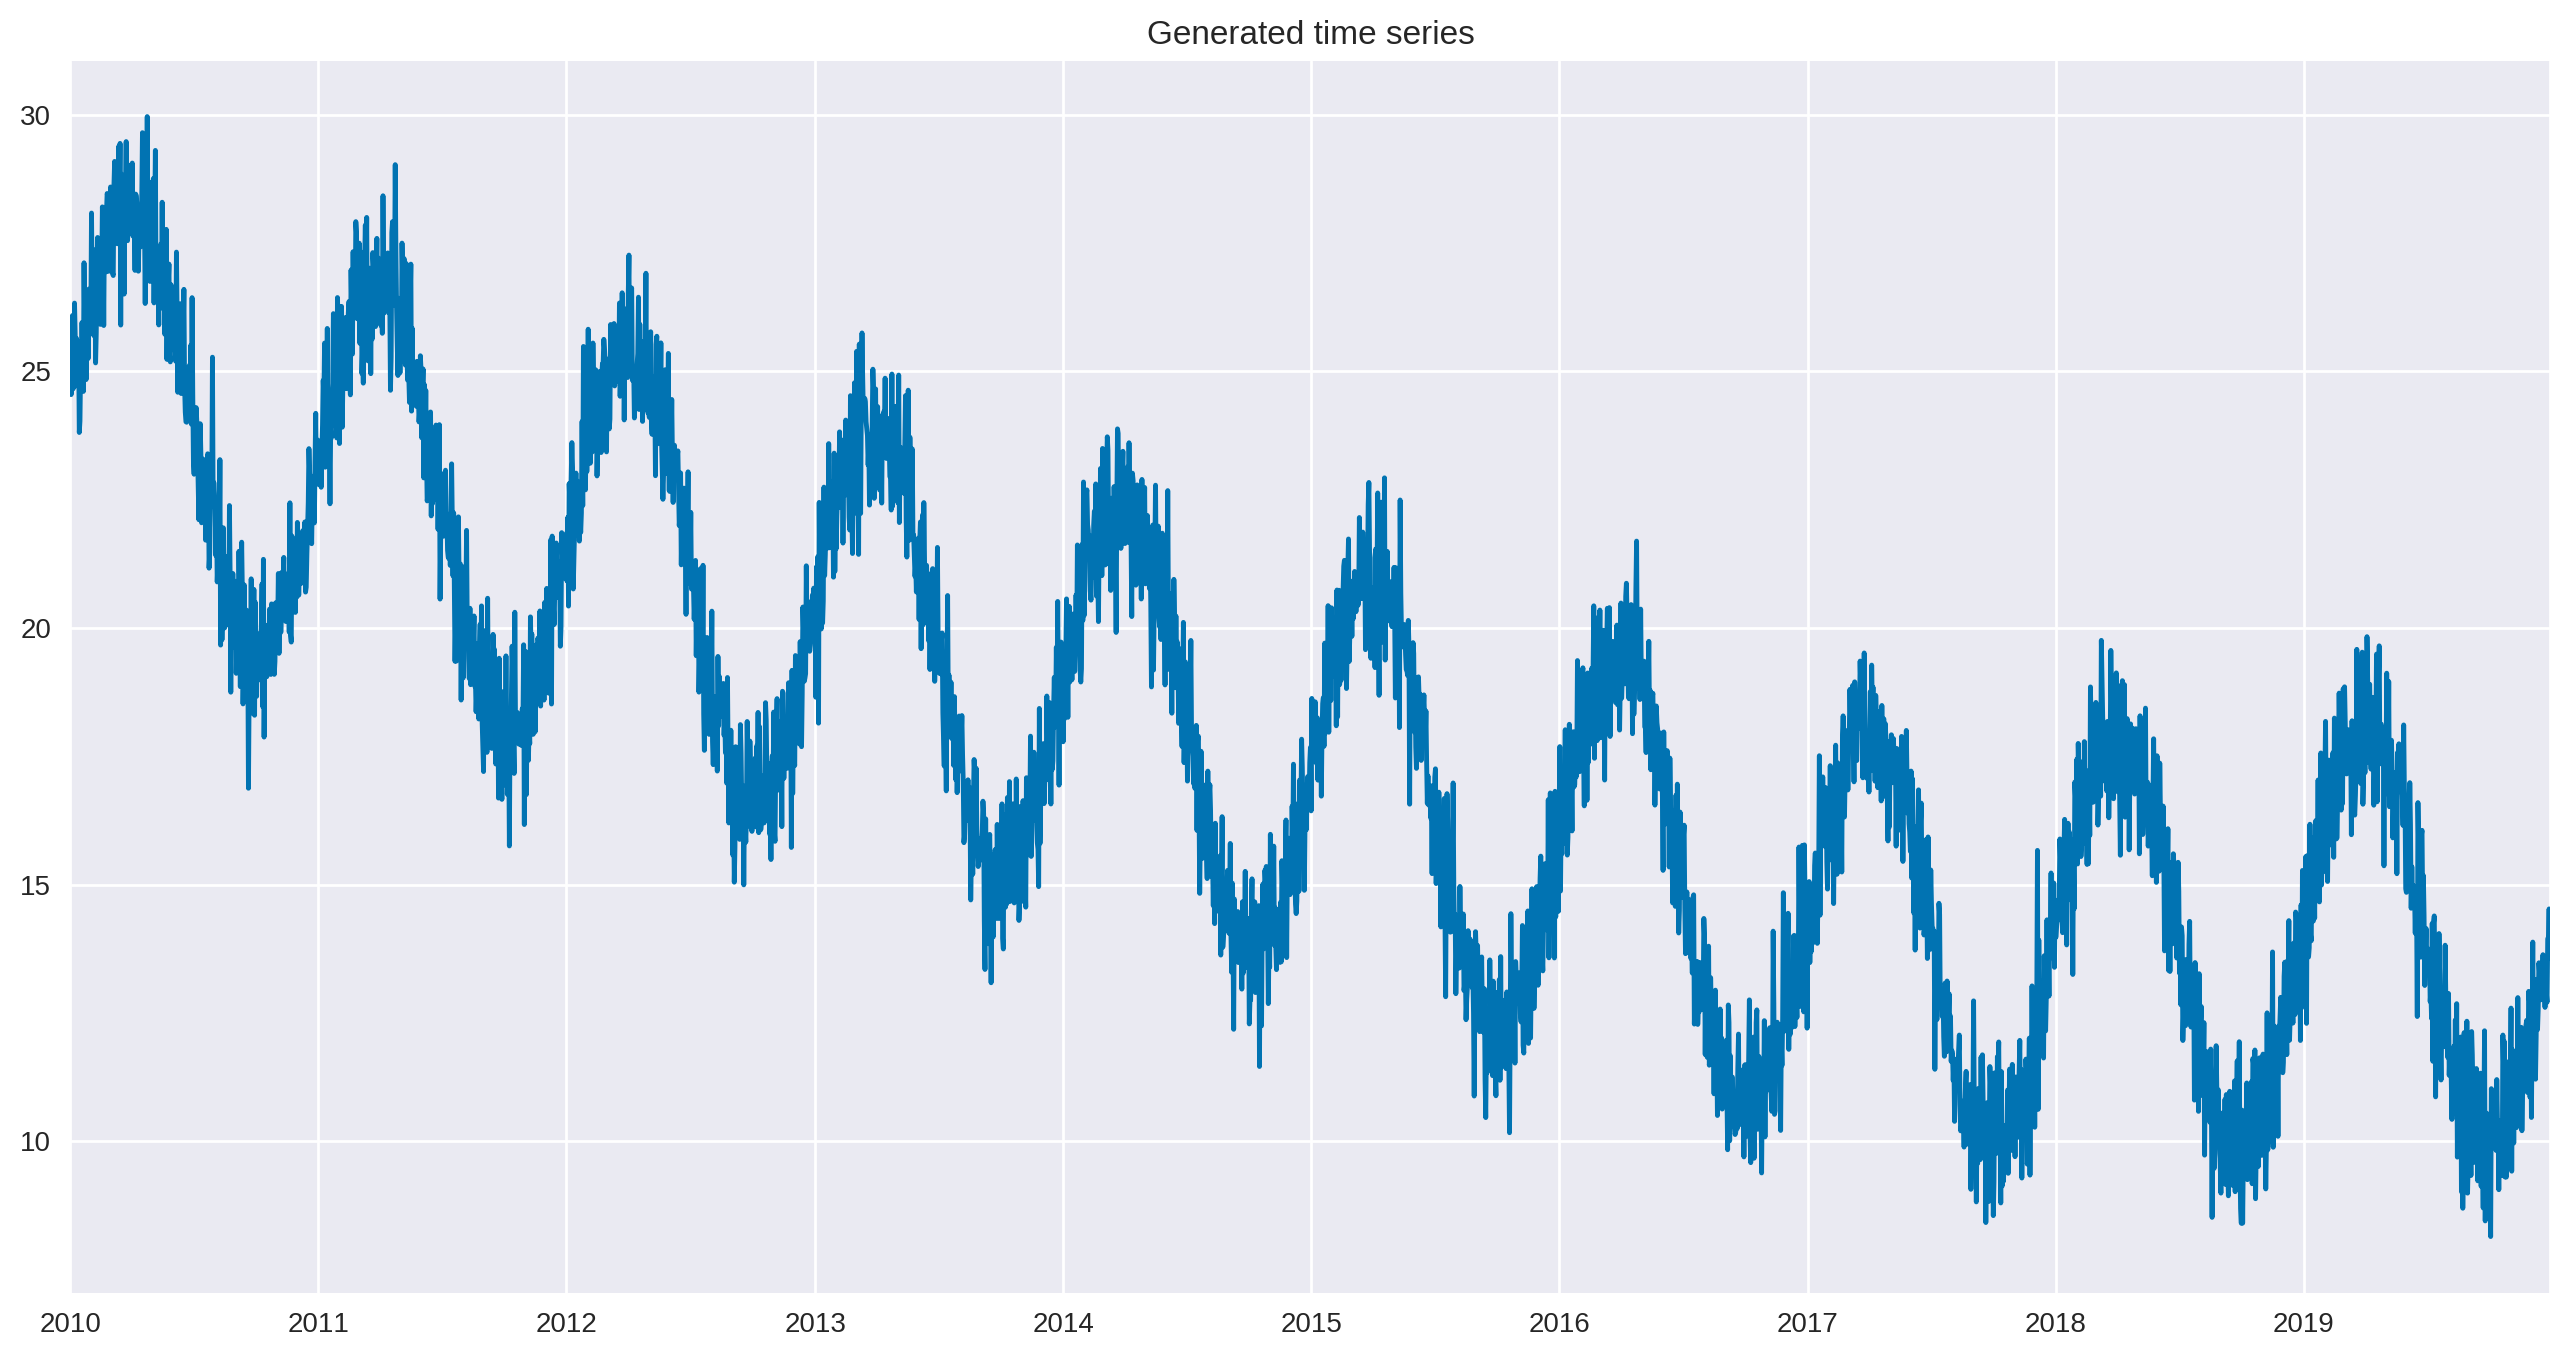

In [7]:
# for reproducibility
np.random.seed(42)

# generate the DataFrame with dates
range_of_dates = pd.date_range(
    start="2010-01-01",
    end="2019-12-30"
)
df = pd.DataFrame(index=range_of_dates)

# create a sequence of day numbers
df["linear_trend"] = range(len(df))
df["trend"] = 0.004 * df["linear_trend"].values[::-1]
df.loc["2017-01-01":, "trend"] = 4

# generate the components of the target
signal_1 = 10 + 4 * np.sin(df["linear_trend"] / 365 * 2 * np.pi)
noise = np.random.normal(0, 0.85, len(df))

# combine them to get the target series
df["target"] = signal_1 + noise + df["trend"]

# plot
df["target"].plot(title="Generated time series");


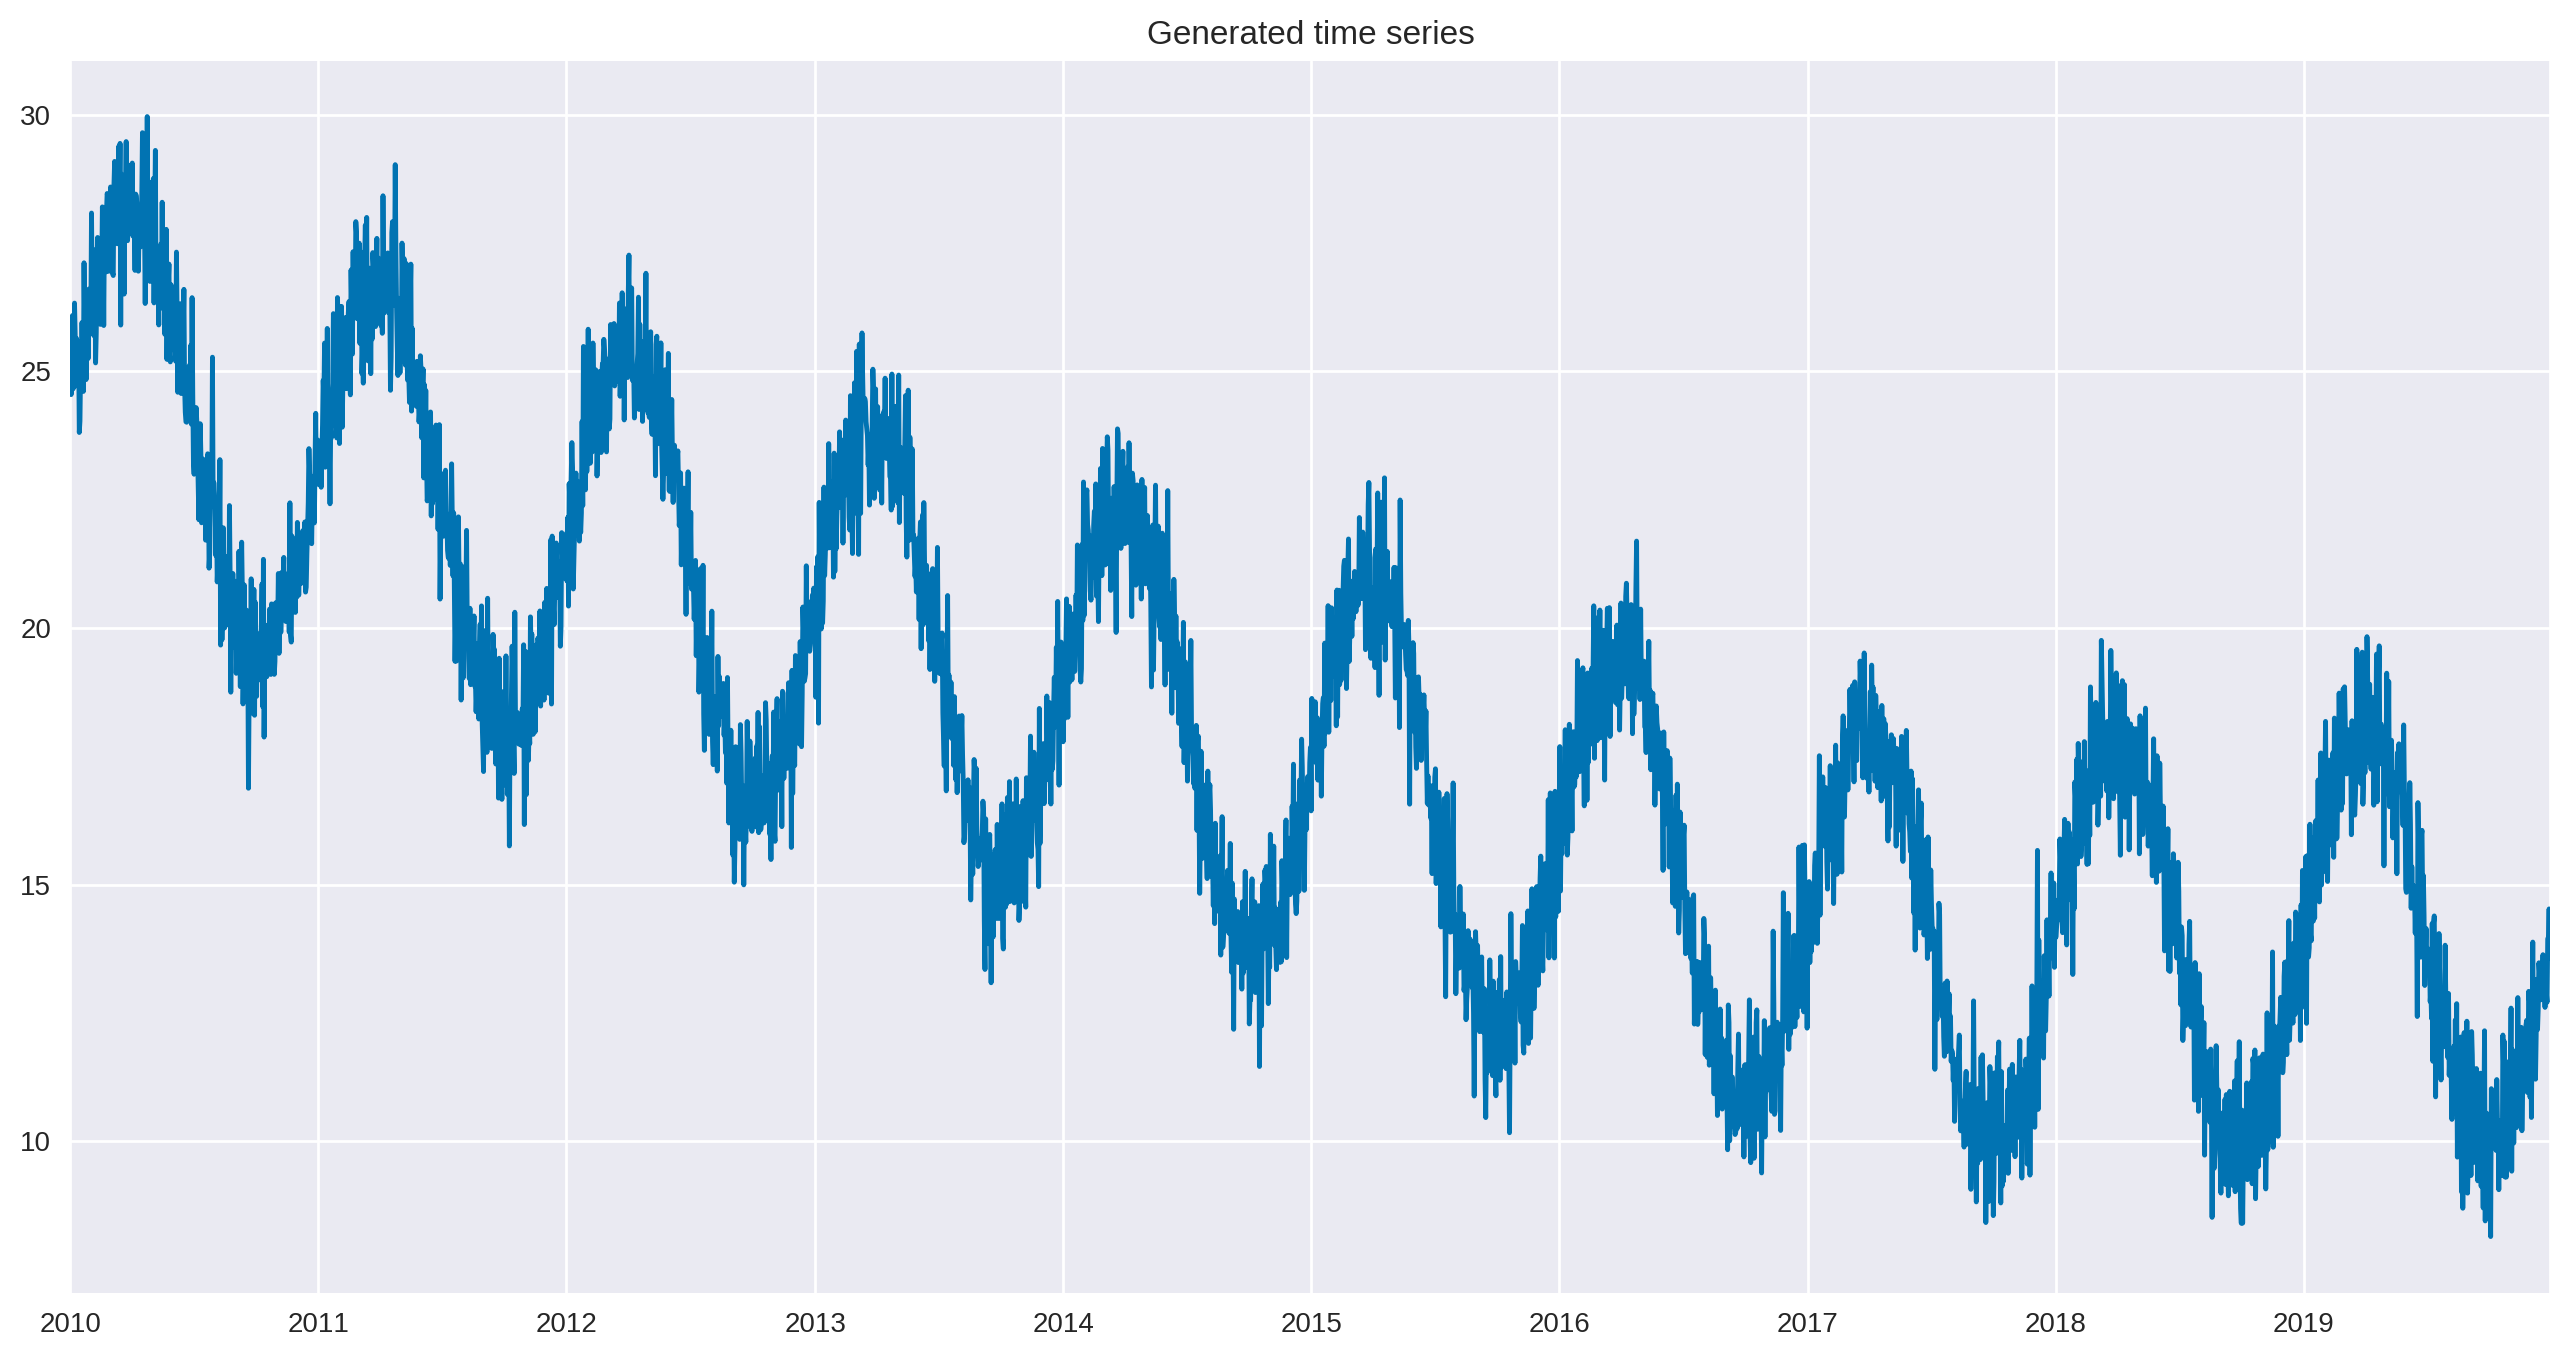

In [8]:
cu_df = cudf.from_pandas(df)
cu_df["target"].to_pandas().plot(title="Generated time series");

## Linear trend

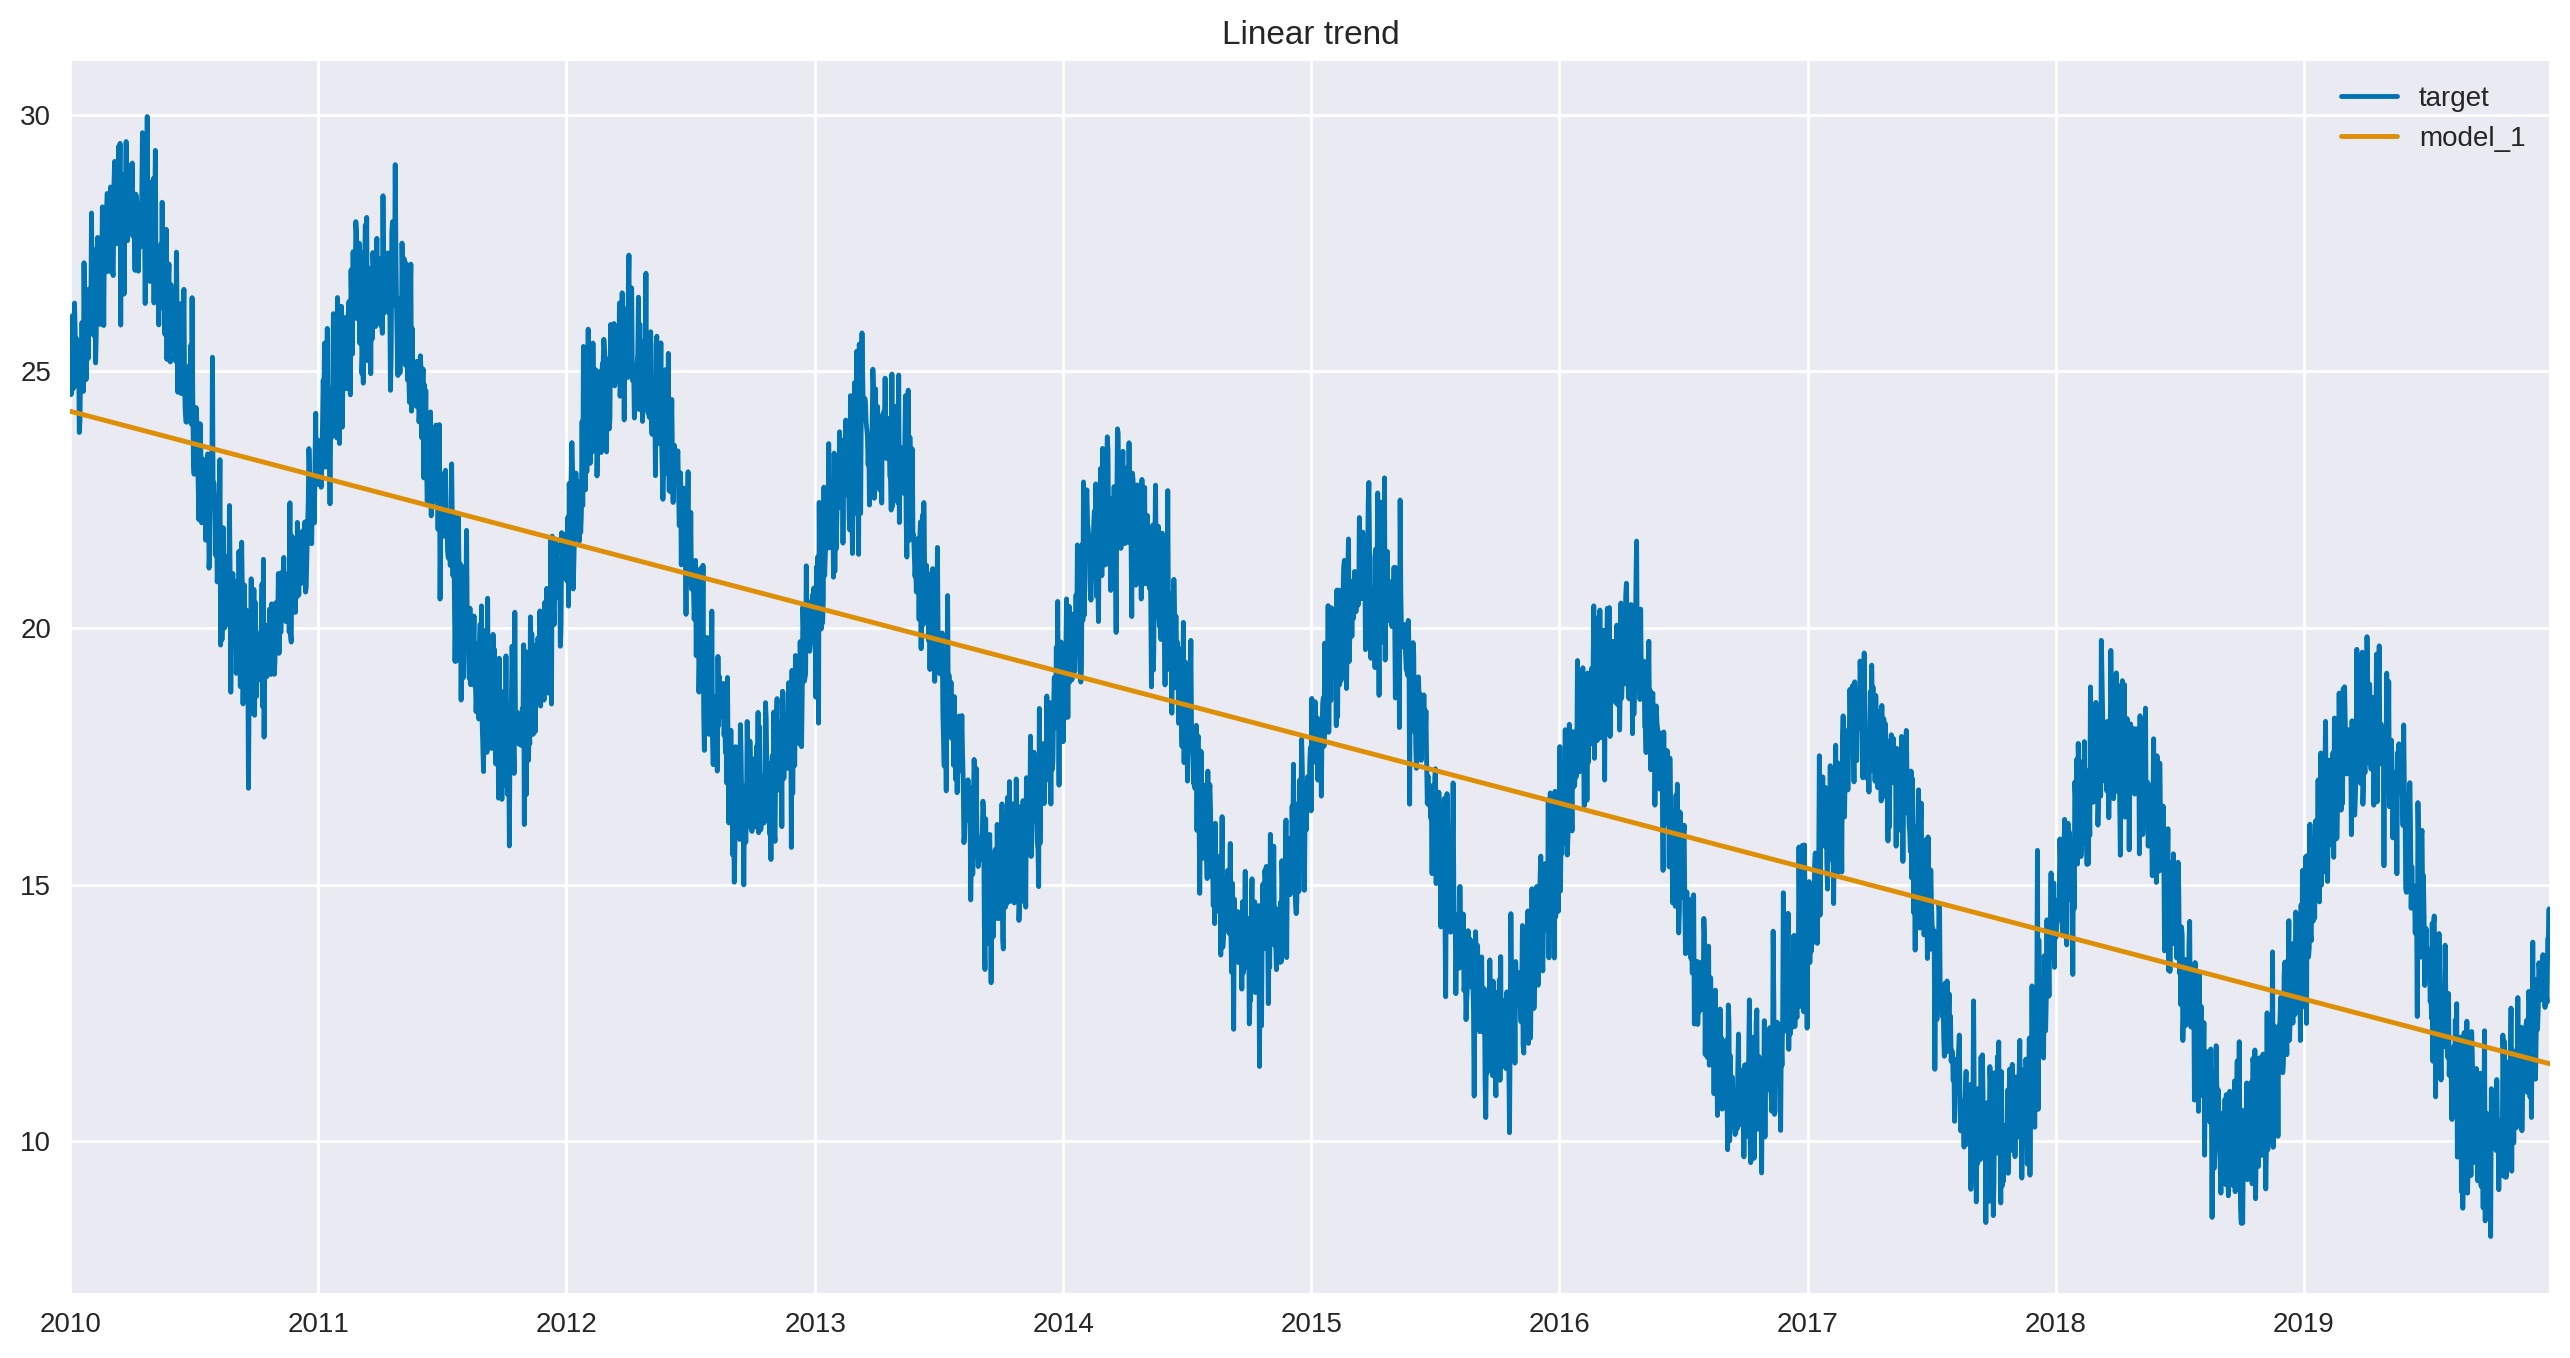

In [9]:
X = df[["linear_trend"]]
y = df[["target"]]

lm = LinearRegression()
lm.fit(X, y)

df["model_1"] = lm.predict(X)

df[["target", "model_1"]].plot(title="Linear trend");

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:190: UserWarning: Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.
  return func(*args, **kwargs)


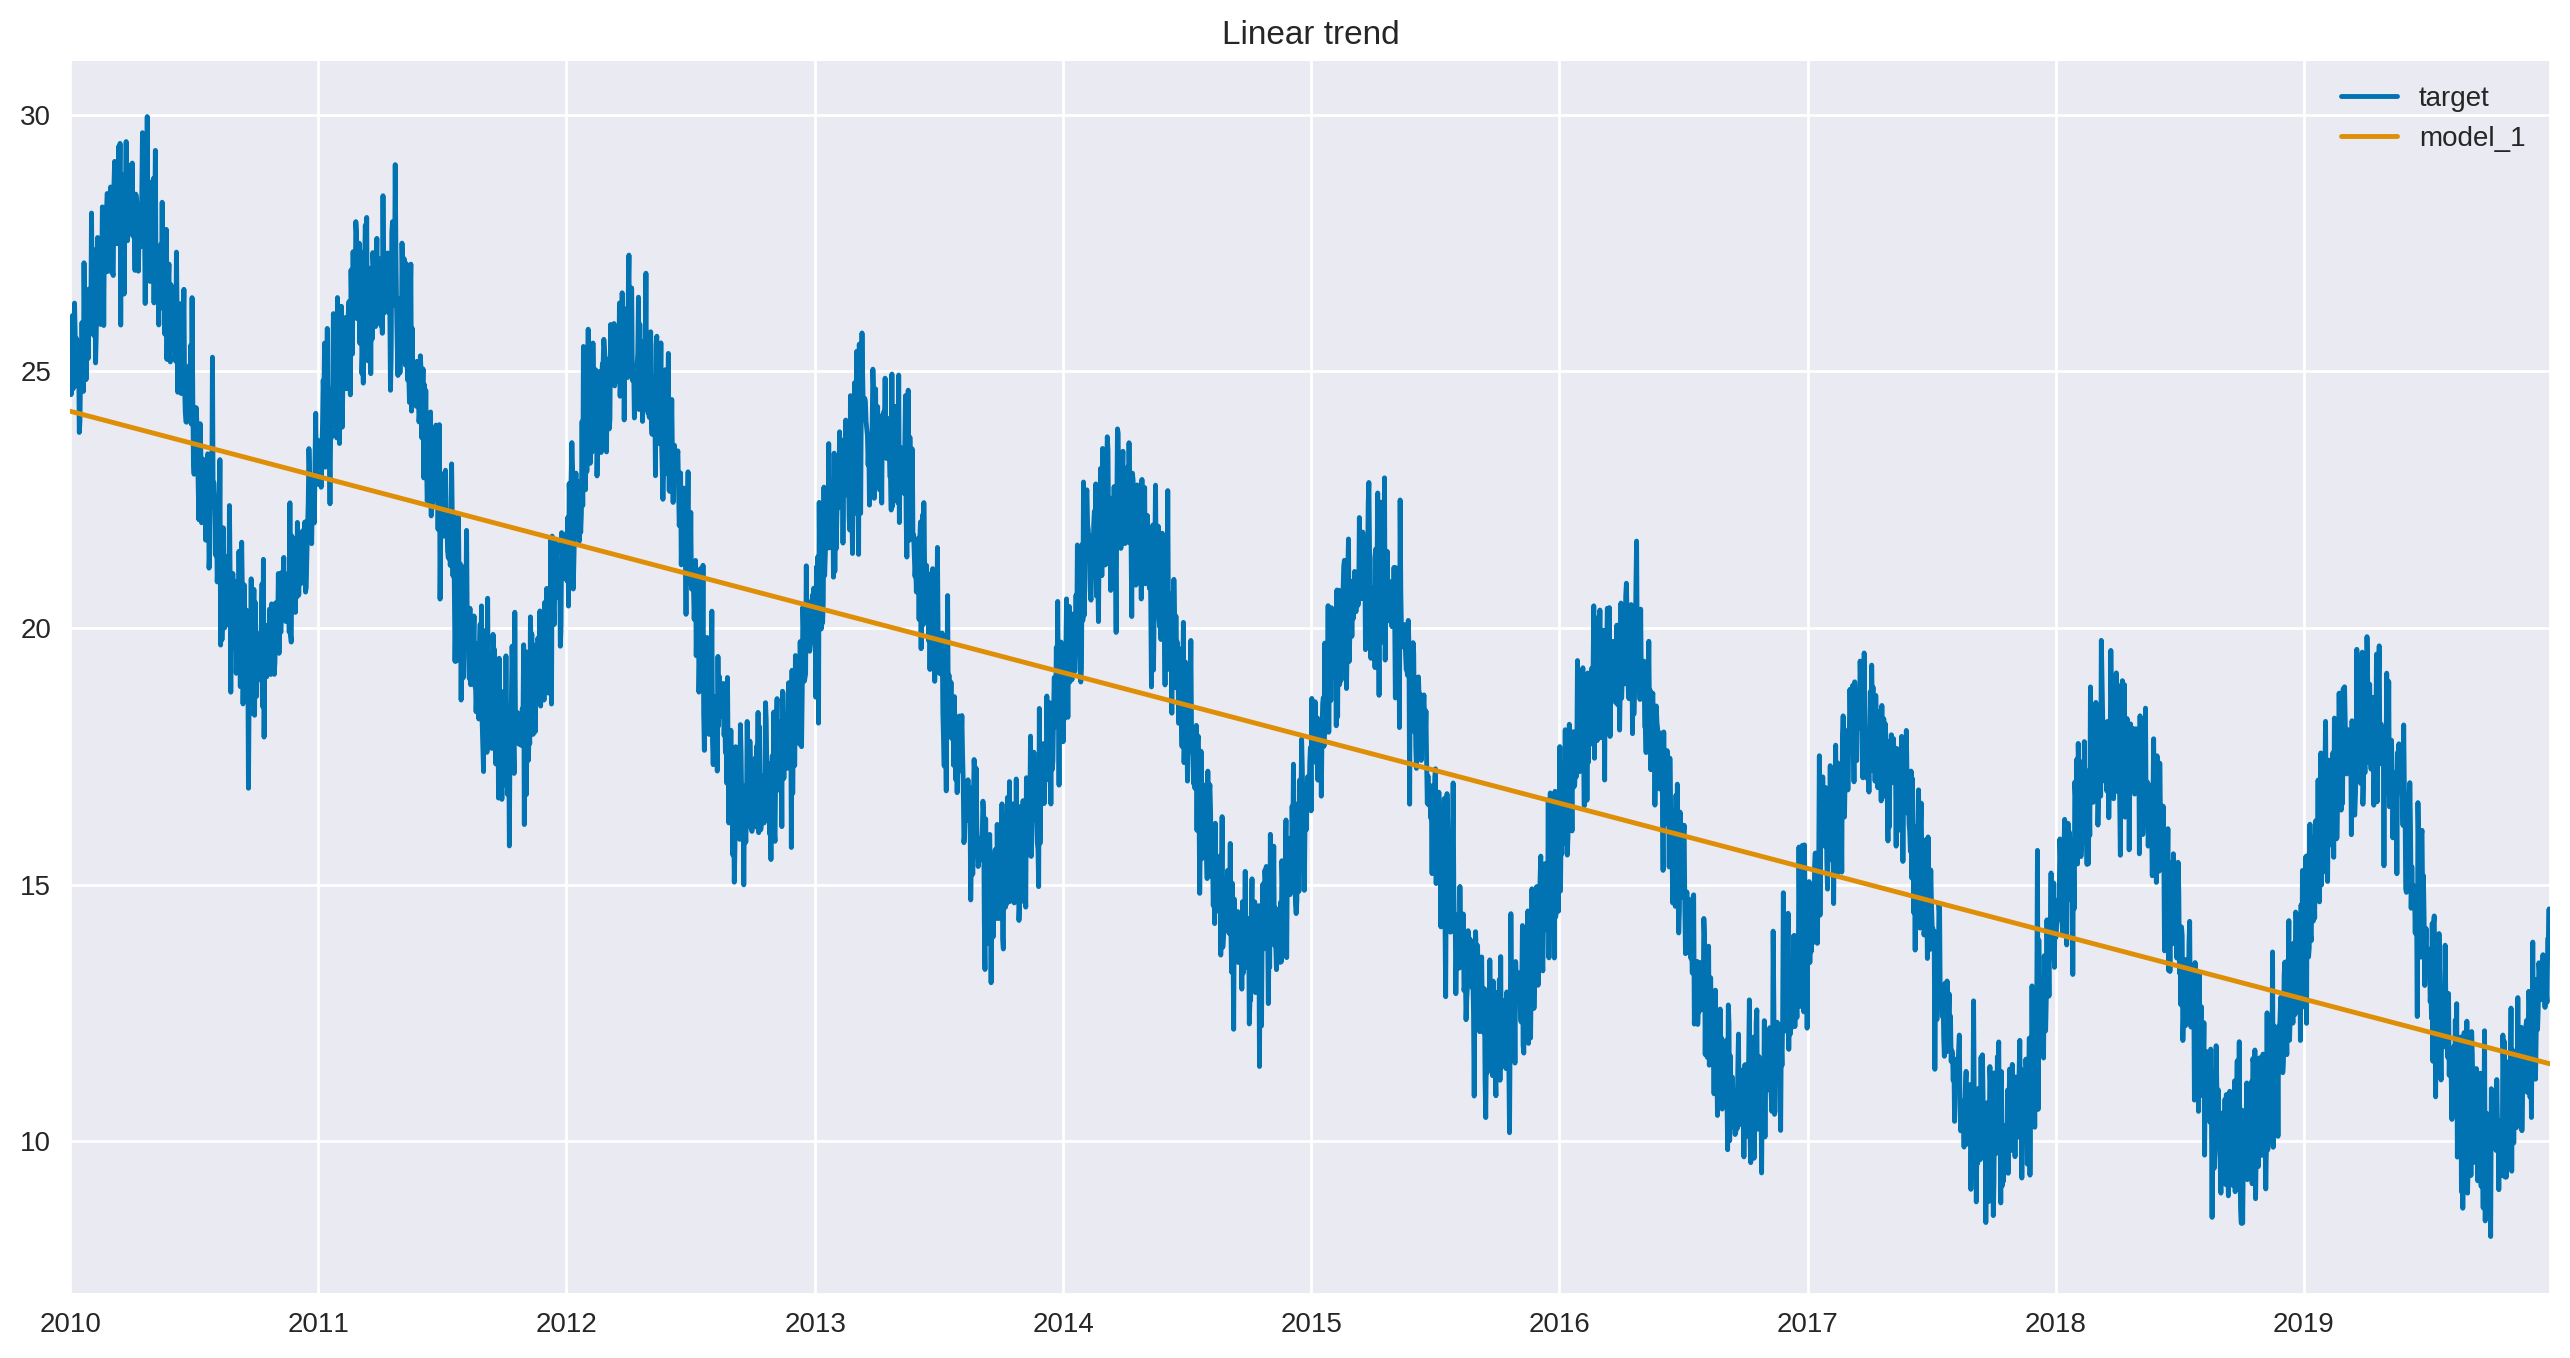

In [10]:
X = cu_df[["linear_trend"]].astype('float32')
y = cu_df[["target"]].astype('float32')

lm = cuLR()
lm.fit(X, y)

cu_df["model_1"] = lm.predict(X)

cu_df[["target", "model_1"]].to_pandas().plot(title="Linear trend");

## Linear trend + breakpoint

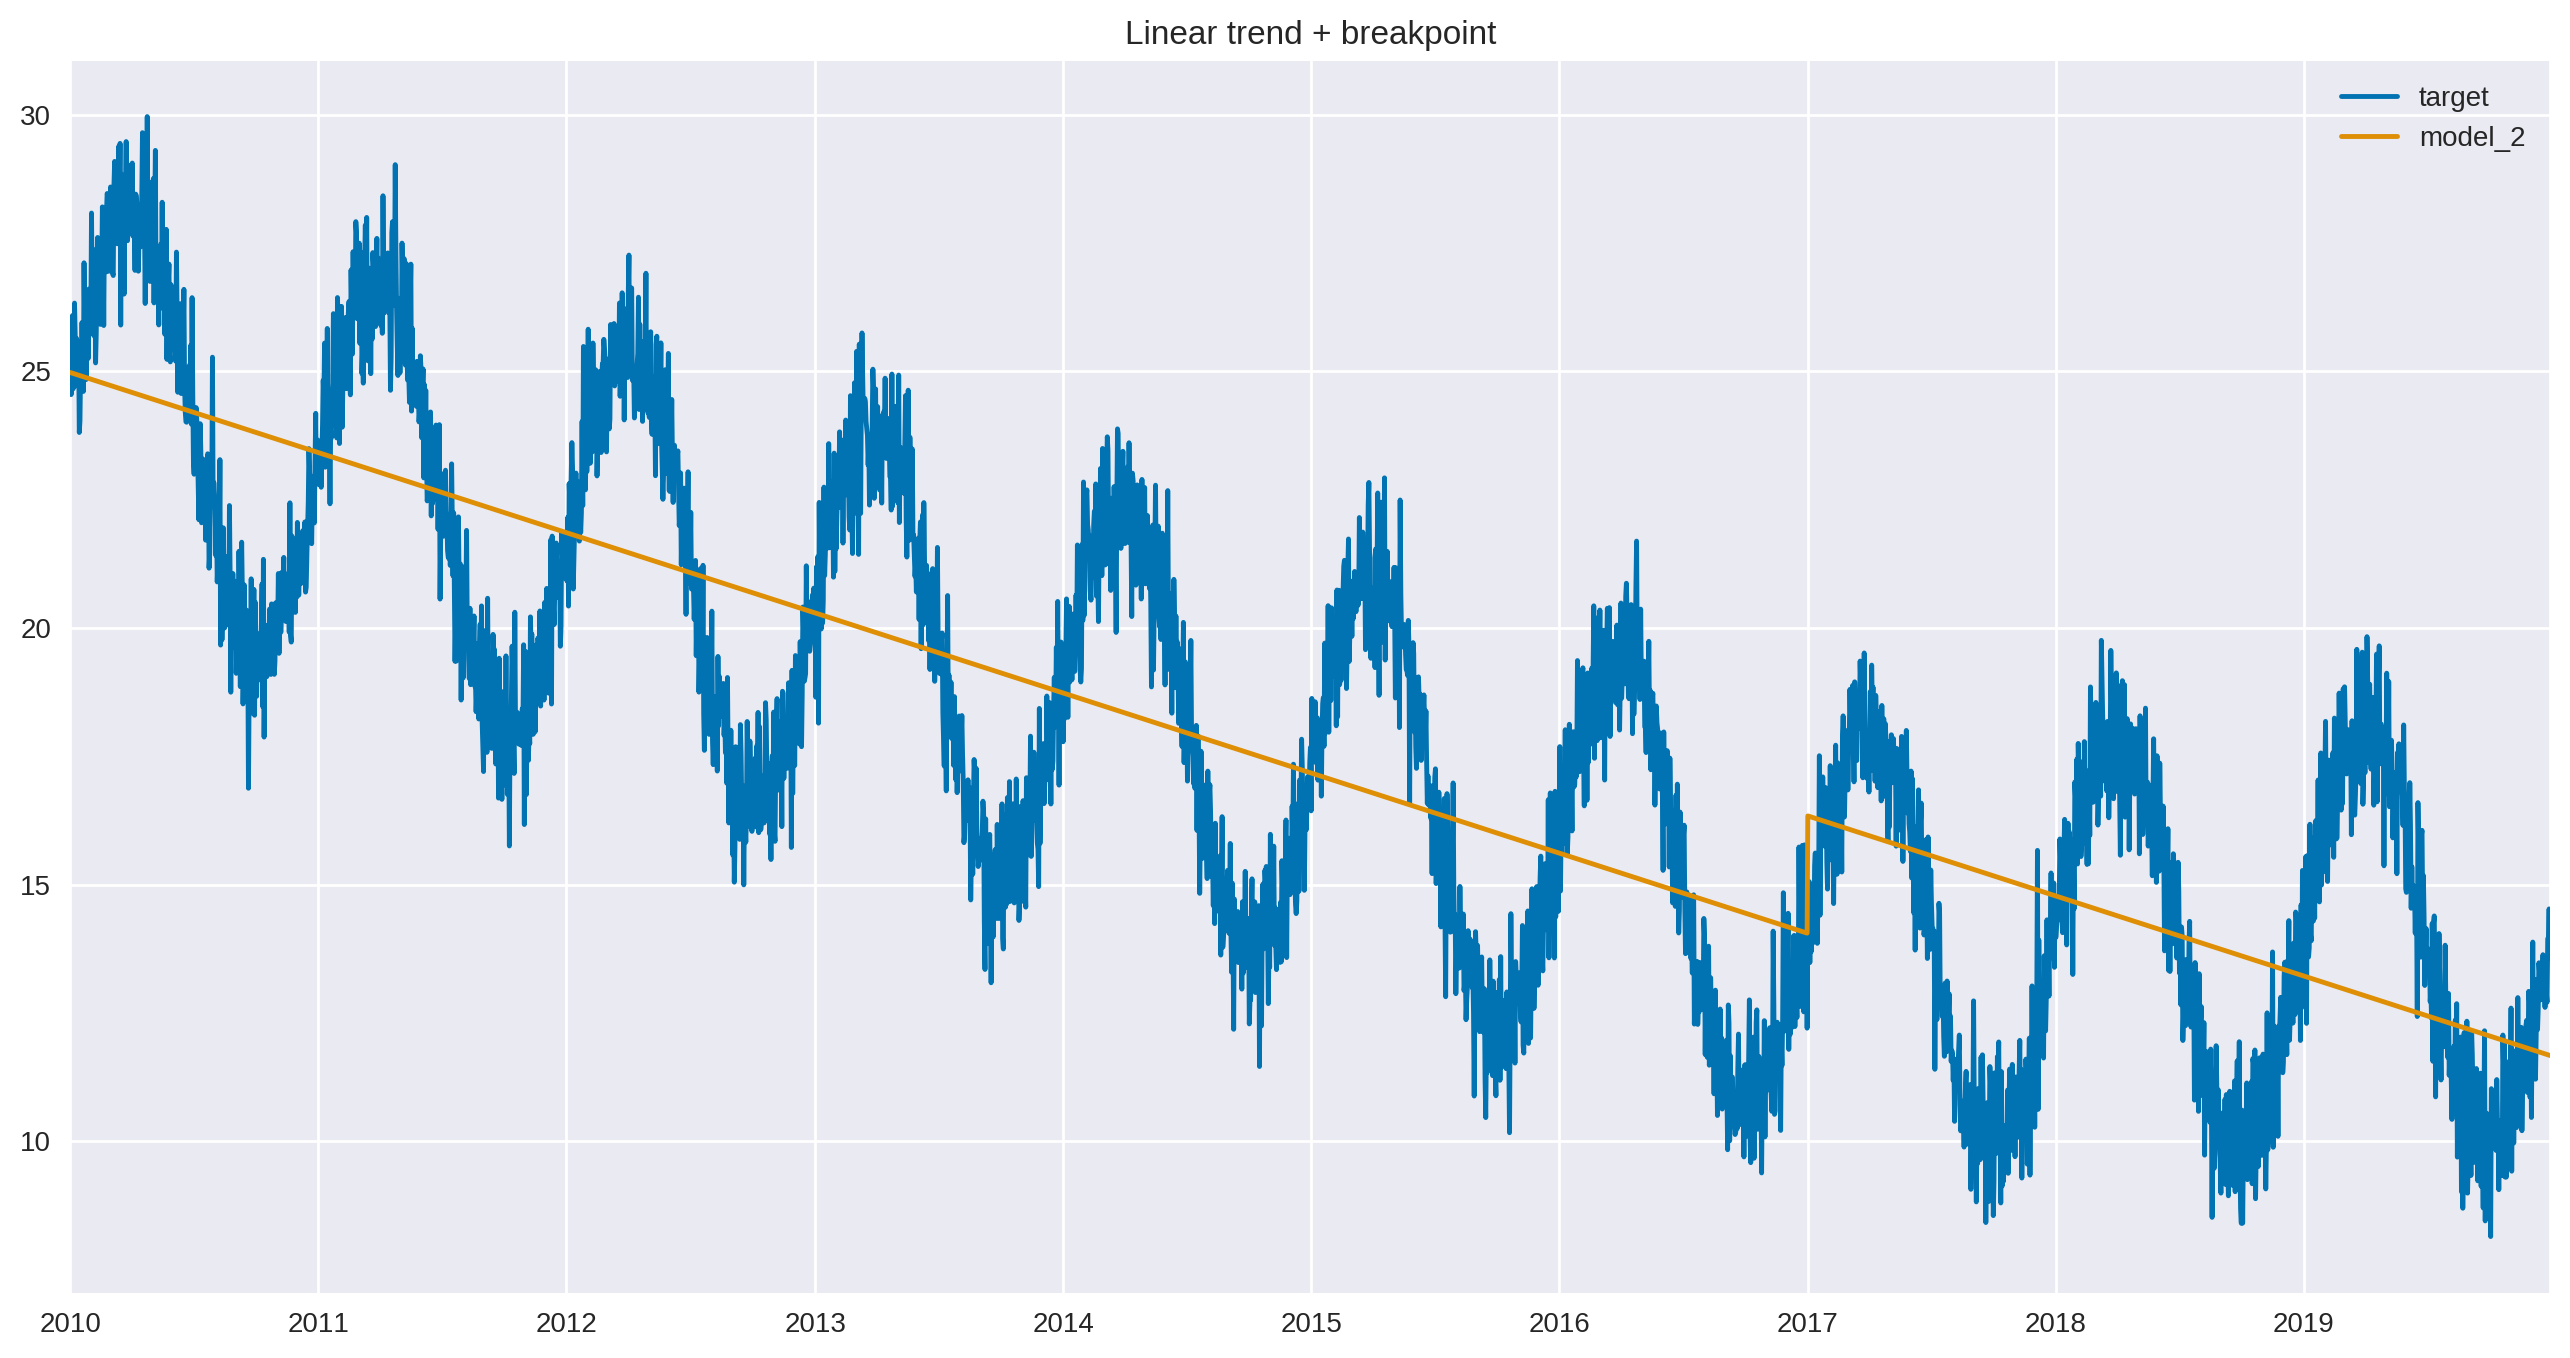

In [11]:
df["after_2017_breakpoint"] = np.where(df.index >= pd.Timestamp('2017-01-01'), 1, 0)

X = df[["linear_trend", "after_2017_breakpoint"]]
y = df[["target"]]

lm = LinearRegression()
lm.fit(X, y)

df["model_2"] = lm.predict(X)

df[["target", "model_2"]].plot(title="Linear trend + breakpoint");

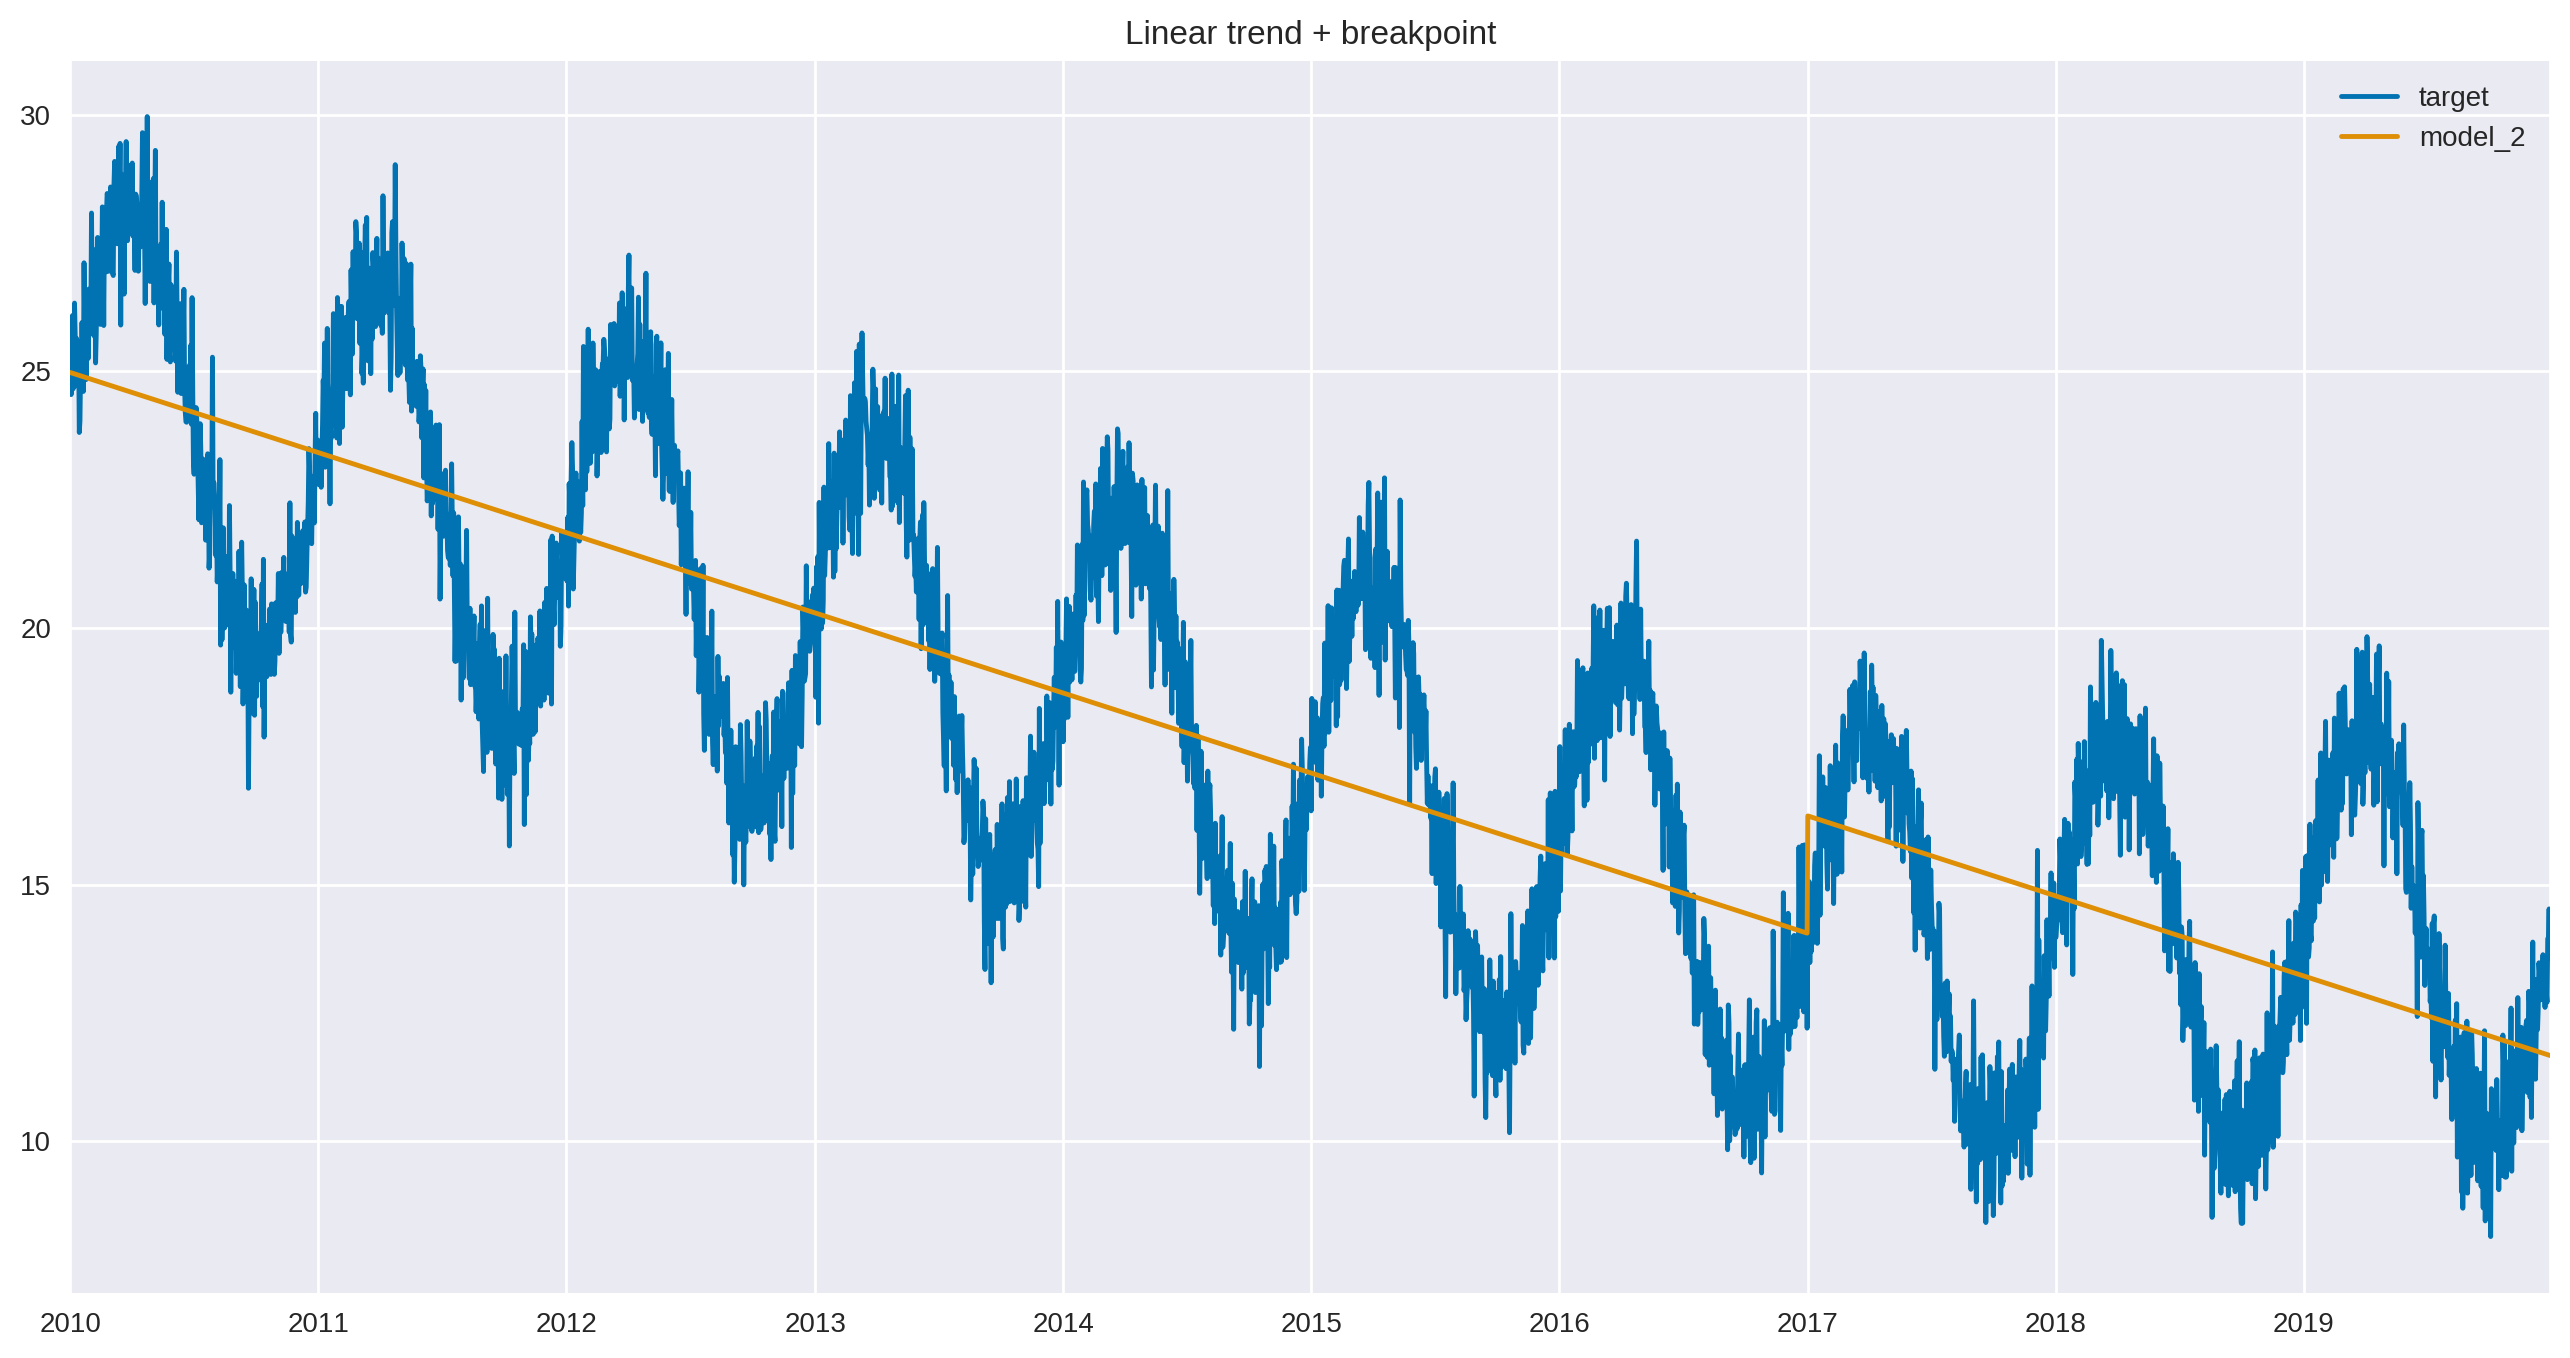

In [14]:
cu_df["after_2017_breakpoint"] = (cu_df.index >= np.datetime64('2017-01-01')).astype(cp.float32)

X = cu_df[["linear_trend", "after_2017_breakpoint"]]
y = cu_df[["target"]]

lm = cuLR()
lm.fit(X, y)

cu_df["model_2"] = lm.predict(X)

cu_df[["target", "model_2"]].to_pandas().plot(title="Linear trend + breakpoint");

## Linear trend + breakpoint + interaction term

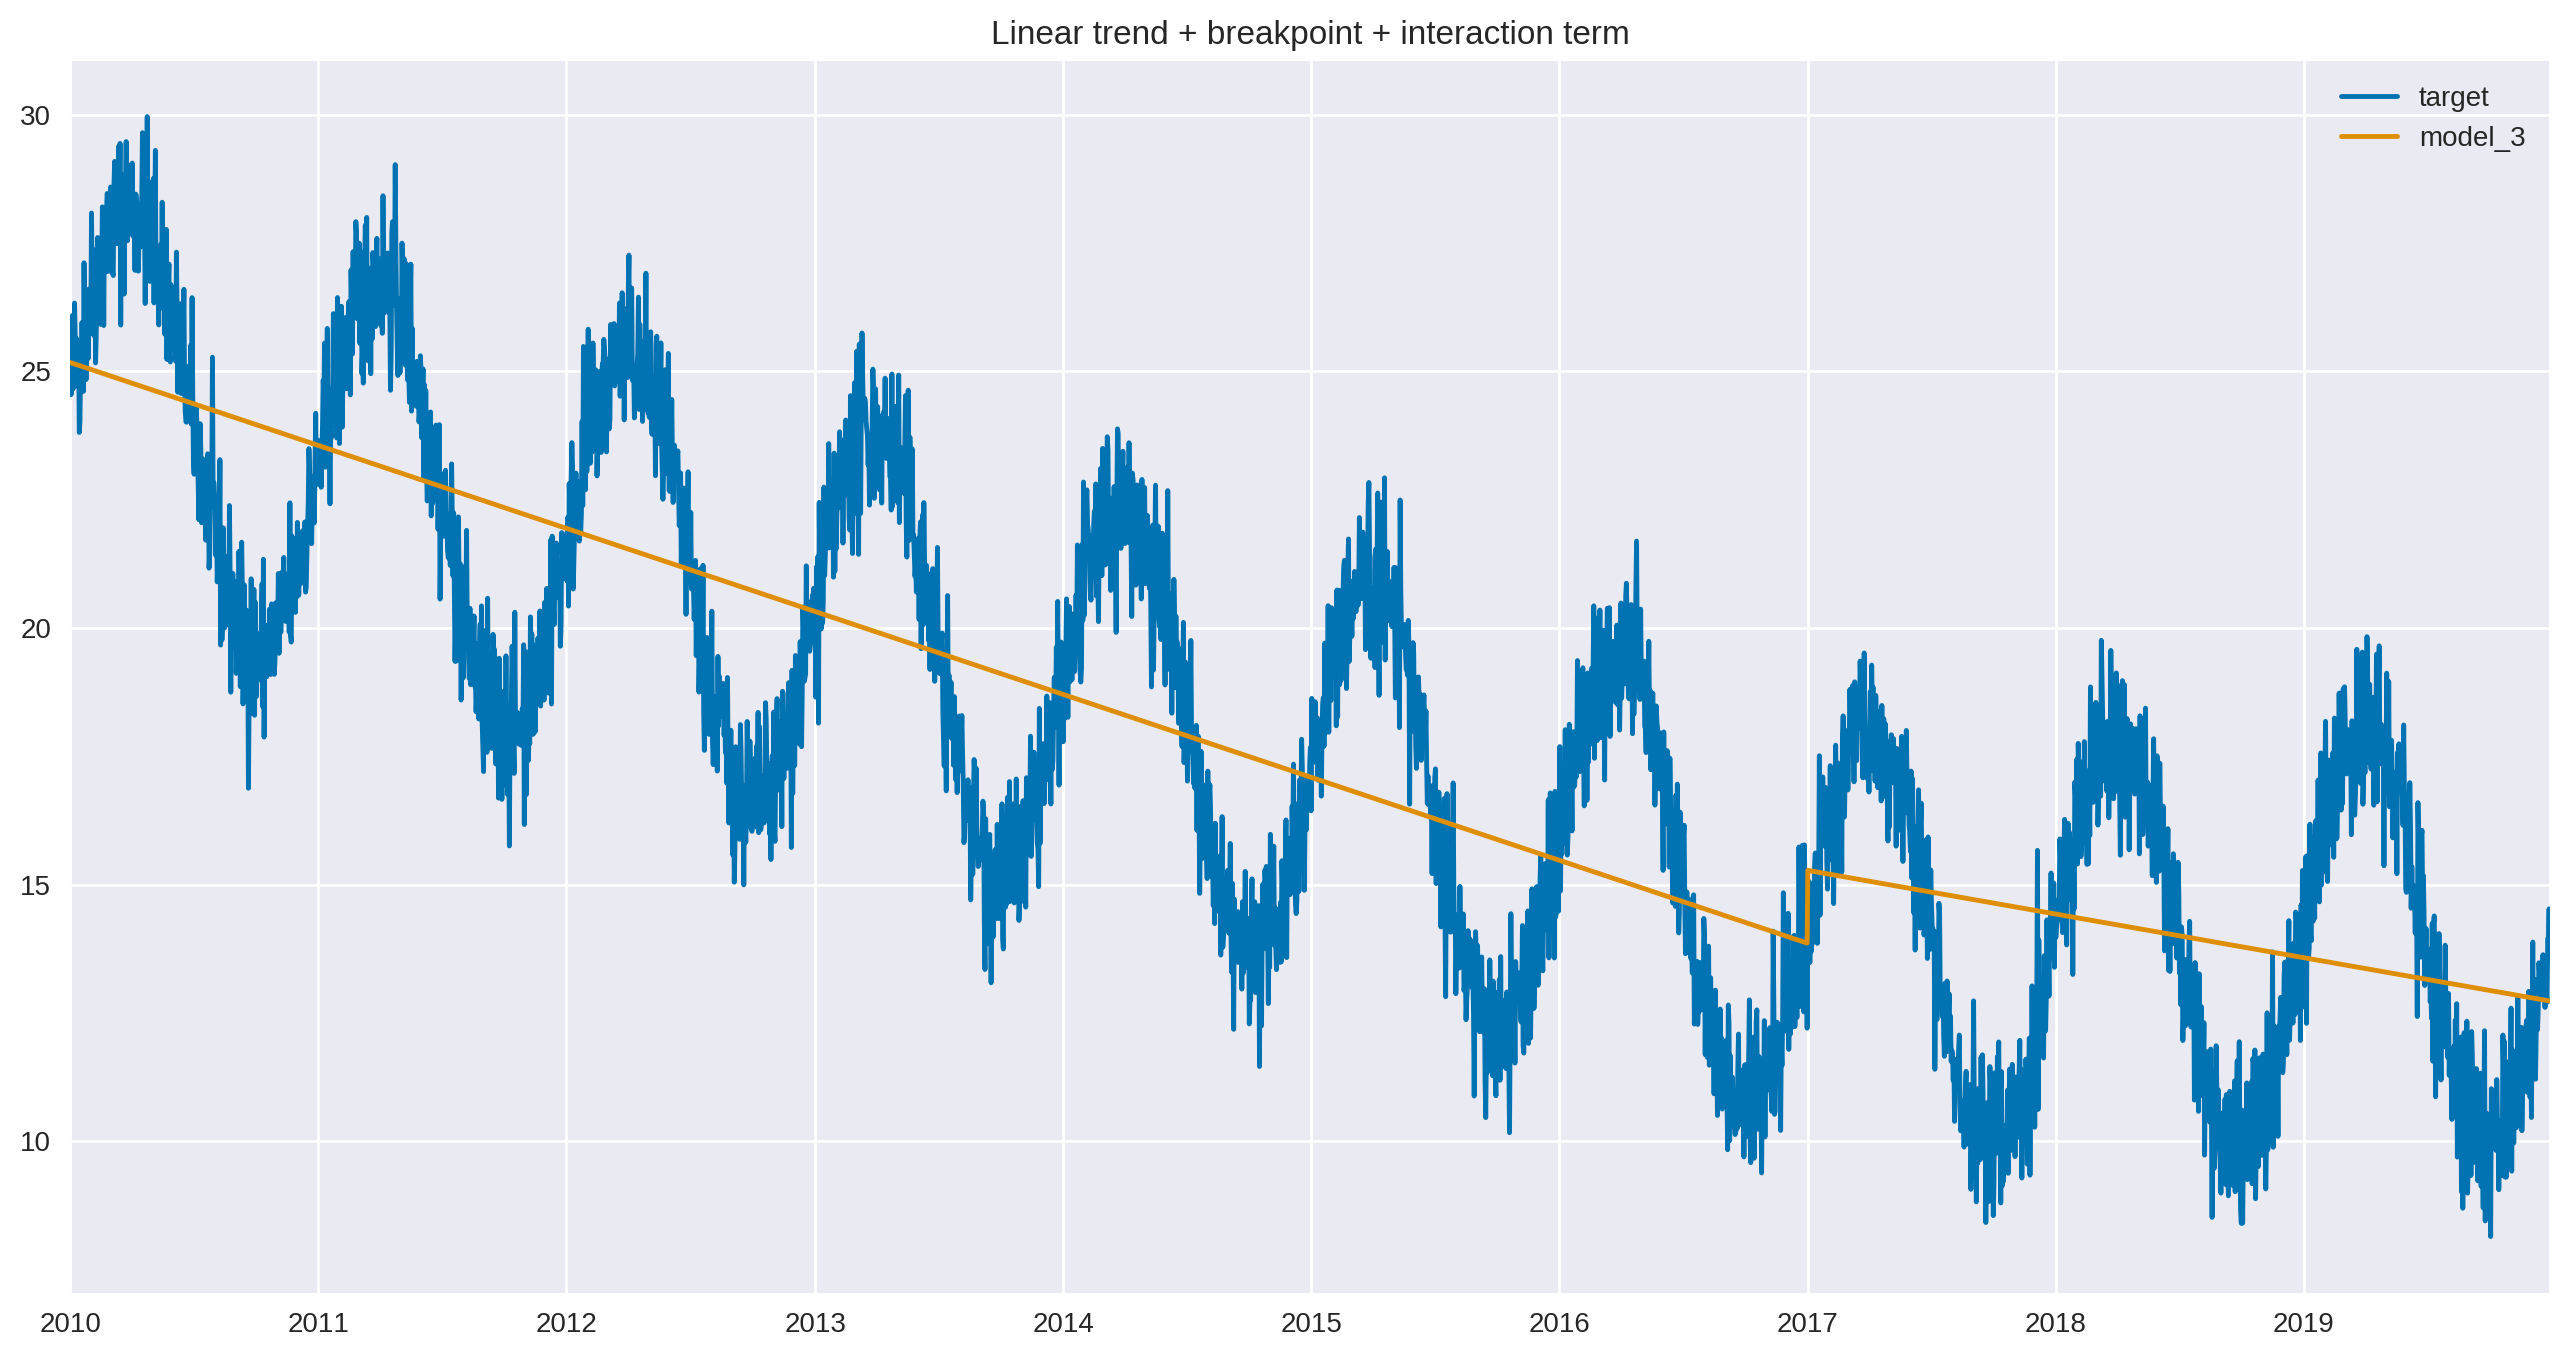

In [15]:
df["interaction_term"] = df["after_2017_breakpoint"] * df["linear_trend"]

X = df[["linear_trend", "after_2017_breakpoint", "interaction_term"]]
y = df[["target"]]

lm = LinearRegression()
lm.fit(X, y)

df["model_3"] = lm.predict(X)

df[["target", "model_3"]].plot(title="Linear trend + breakpoint + interaction term");

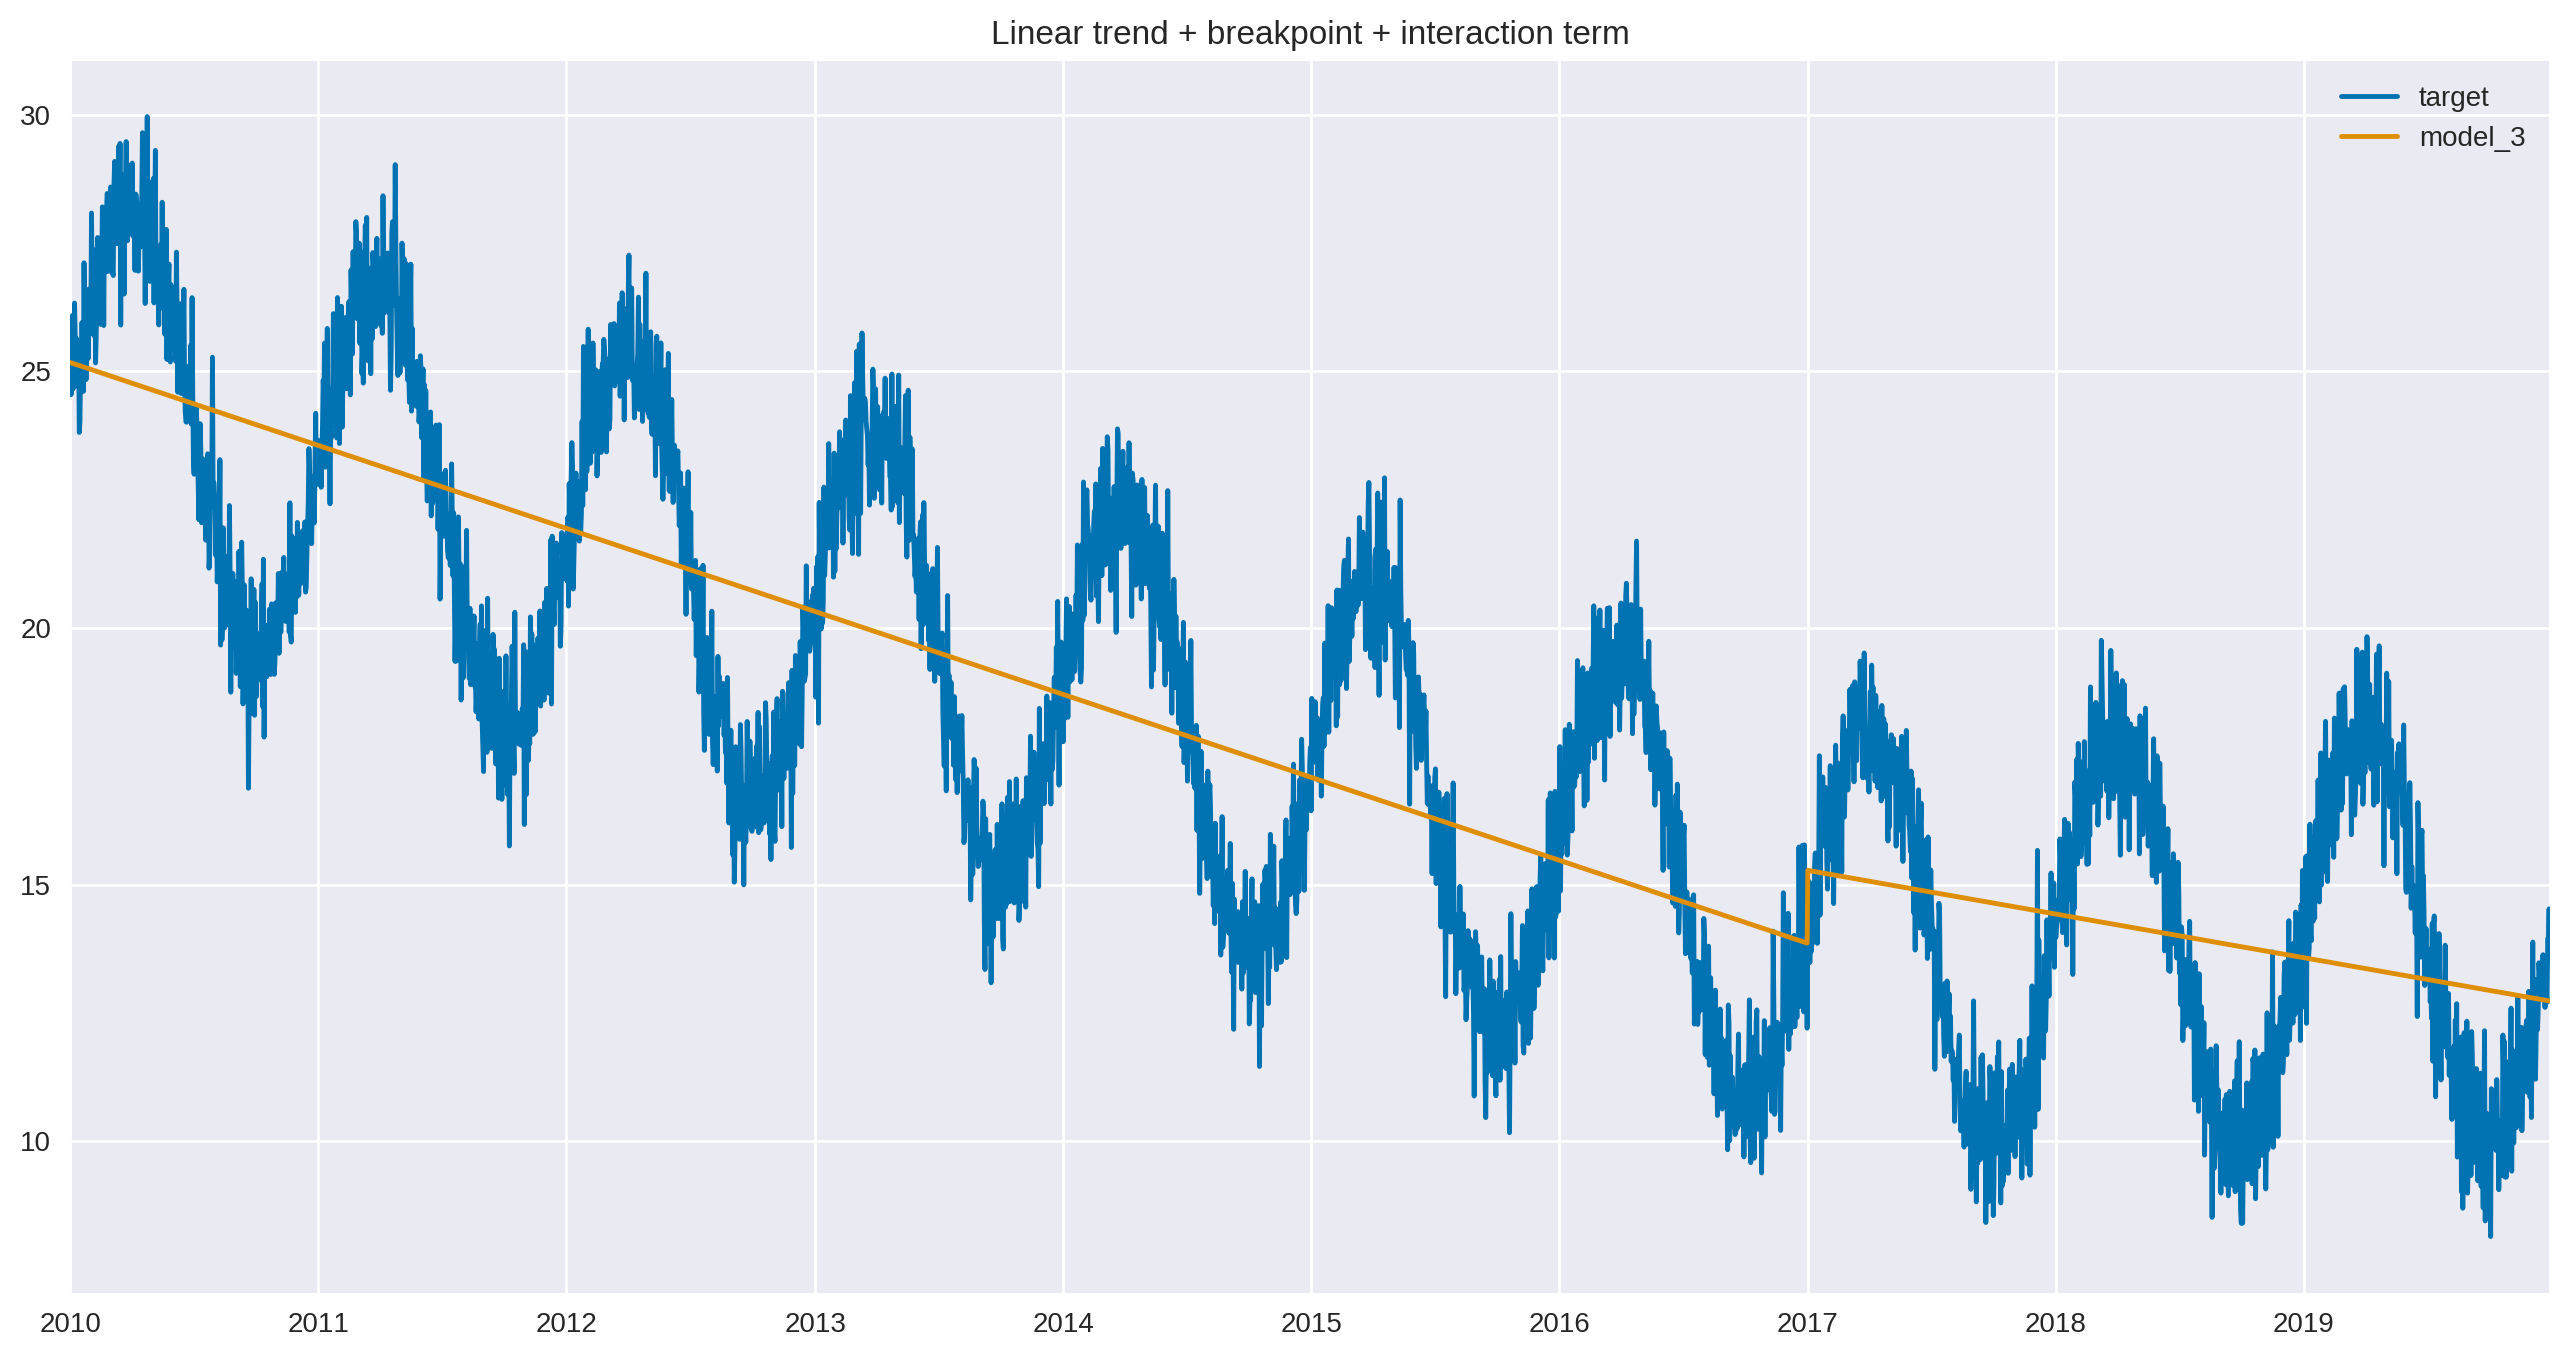

In [16]:
cu_df["interaction_term"] = cu_df["after_2017_breakpoint"] * cu_df["linear_trend"]

X = cu_df[["linear_trend", "after_2017_breakpoint", "interaction_term"]]
y = cu_df[["target"]]

lm = cuLR()
lm.fit(X, y)

cu_df["model_3"] = lm.predict(X)

cu_df[["target", "model_3"]].to_pandas().plot(title="Linear trend + breakpoint + interaction term");